# 05 — d=3 Rotated Surface Code (Surface-17)

- 拓扑图（Surface-17 teaching lattice：data / ancilla / 连接关系）
- 分模块电路：Z 稳定子测量、X 稳定子测量
- **完整一轮** d=3 纠错轮次电路（含所有 stabilizer 的测量）
- 注入单比特 X/Z 错误 → 返回综合征 → toy 解码 → 反馈纠错 → 再测一轮验证
- 过程中**每一步都输出对应电路图**（用于对照理解）

> 说明：本 Notebook 采用的是 Surface-17 patch（9 data + 4 Z-plaquette ancilla + 4 X-boundary ancilla = 17 qubits）

In [2]:
# ---- imports ----
import re
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

## 1. Surface-17 (d=3 rotated patch) 拓扑定义

- data qubit：`d0..d8`（3×3）
- Z stabilizer ancilla：`az0..az3`（**2 个 weight-4 plaquette + 2 个 boundary weight-2**）
- X stabilizer ancilla：`ax0..ax3`（**2 个 weight-4 plaquette + 2 个 boundary weight-2**）

下方 `Z_CHECKS / X_CHECKS` 的 `data` 列表，就是“某个稳定子测量时，会与哪些 data qubit 发生耦合”的拓扑定义。

> 说明：你上传的拓扑图对应 **4 个中心 plaquette（X/Z 交替）+ 4 个边界 stabilizer（左右为 X、上下为 Z）**，总计 8 个稳定子、8 个 ancilla（即 Surface-17）。


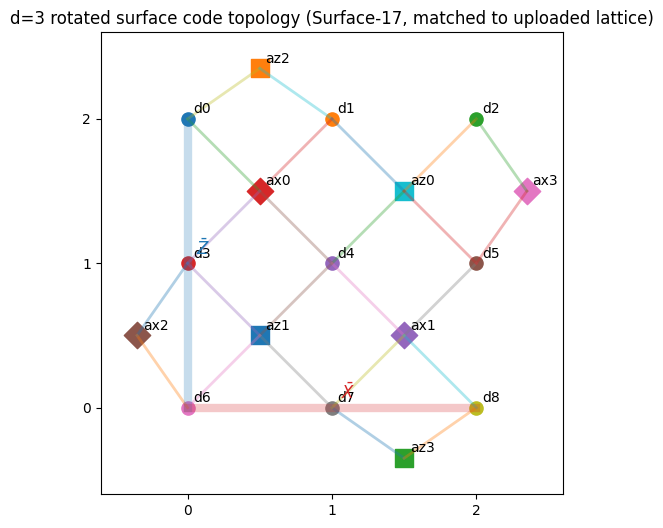

In [3]:
# ---- topology (Surface-17 rotated patch, consistent with uploaded lattice) ----

DATA = [f"d{i}" for i in range(9)]
AZ   = [f"az{i}" for i in range(4)]  # Z-type ancillas (2 plaquette + 2 boundary)
AX   = [f"ax{i}" for i in range(4)]  # X-type ancillas (2 plaquette + 2 boundary)

# data coordinates (for plotting): 3x3 data (d0..d8)
#   d0 d1 d2
#   d3 d4 d5
#   d6 d7 d8
DATA_COORDS = {
    "d0": (0,2), "d1": (1,2), "d2": (2,2),
    "d3": (0,1), "d4": (1,1), "d5": (2,1),
    "d6": (0,0), "d7": (1,0), "d8": (2,0),
}

# In the uploaded topology sketch, the 2x2 interior stabilizers alternate:
#   (top-left)  X   |  (top-right) Z
#   (bot-left)  Z   |  (bot-right) X
# and there are 4 truncated boundary stabilizers:
#   top/bottom are Z-type (weight-2), left/right are X-type (weight-2).

# Z-type stabilizers: 2 weight-4 plaquettes + 2 weight-2 boundaries
Z_CHECKS = [
    {"name":"Zp0", "anc":"az0", "data":["d1","d2","d4","d5"]},  # top-right (weight-4)
    {"name":"Zp1", "anc":"az1", "data":["d3","d4","d6","d7"]},  # bottom-left (weight-4)
    {"name":"ZsT", "anc":"az2", "data":["d0","d1"]},              # top boundary (weight-2)
    {"name":"ZsB", "anc":"az3", "data":["d7","d8"]},              # bottom boundary (weight-2)
]

# X-type stabilizers: 2 weight-4 plaquettes + 2 weight-2 boundaries
X_CHECKS = [
    {"name":"Xp0", "anc":"ax0", "data":["d0","d1","d3","d4"]},  # top-left (weight-4)
    {"name":"Xp1", "anc":"ax1", "data":["d4","d5","d7","d8"]},  # bottom-right (weight-4)
    {"name":"XsL", "anc":"ax2", "data":["d3","d6"]},               # left boundary (weight-2)
    {"name":"XsR", "anc":"ax3", "data":["d2","d5"]},               # right boundary (weight-2)
]

def plot_surface17_topology(show_logicals=True):
    fig, ax = plt.subplots(figsize=(6,6))

    # helper: center of a stabilizer from its incident data qubits
    def center_of(dlist):
        xs, ys = [], []
        for d in dlist:
            x,y = DATA_COORDS[d]
            xs.append(x); ys.append(y)
        return float(np.mean(xs)), float(np.mean(ys))

    # fixed outer positions for boundary stabilizers
    BOUNDARY_POS = {
        "az2": ((DATA_COORDS["d0"][0]+DATA_COORDS["d1"][0])/2, DATA_COORDS["d0"][1]+0.35),  # top Z
        "az3": ((DATA_COORDS["d7"][0]+DATA_COORDS["d8"][0])/2, DATA_COORDS["d7"][1]-0.35),  # bottom Z
        "ax2": (DATA_COORDS["d3"][0]-0.35, (DATA_COORDS["d3"][1]+DATA_COORDS["d6"][1])/2),  # left X
        "ax3": (DATA_COORDS["d2"][0]+0.35, (DATA_COORDS["d2"][1]+DATA_COORDS["d5"][1])/2),  # right X
    }

    # draw data nodes
    for d,(x,y) in DATA_COORDS.items():
        ax.scatter([x],[y], s=90)
        ax.text(x+0.04, y+0.04, d, fontsize=10)

    # draw Z-type stabilizers (squares)
    for stab in Z_CHECKS:
        if len(stab["data"]) == 2:
            cx,cy = BOUNDARY_POS[stab["anc"]]
        else:
            cx,cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker="s", s=180)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # draw X-type stabilizers (diamonds)
    for stab in X_CHECKS:
        if len(stab["data"]) == 2:
            cx,cy = BOUNDARY_POS[stab["anc"]]
        else:
            cx,cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker="D", s=180)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    if show_logicals:
        # one valid choice (not unique) for rotated d=3 patch
        logical_Z = ["d0","d3","d6"]
        logical_X = ["d6","d7","d8"]
        def draw_path(qubits, color, label):
            pts = [DATA_COORDS[q] for q in qubits]
            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]
            ax.plot(xs, ys, linewidth=6, alpha=0.25, color=color)
            ax.text(xs[len(xs)//2]+0.06, ys[len(ys)//2]+0.06, label, fontsize=12, color=color)

        draw_path(logical_Z, "tab:blue", r"$\bar{Z}$")
        draw_path(logical_X, "tab:red",  r"$\bar{X}$")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_title("d=3 rotated surface code topology (Surface-17, matched to uploaded lattice)")
    plt.show()

plot_surface17_topology(show_logicals=True)



## 2. 命名寄存器（让电路图直接显示 d0/az0/ax0 …）

Qiskit 的 `QuantumCircuit(QuantumRegister(..., name=...))` 会把寄存器名显示在电路左侧。
这里我们把每个 qubit 建成 1-qubit 的寄存器，以得到“和拓扑图一致”的线路标签。

In [4]:
def make_named_qubits():
    qregs = {}
    for d in DATA:
        qregs[d] = QuantumRegister(1, d)
    for a in AZ:
        qregs[a] = QuantumRegister(1, a)
    for a in AX:
        qregs[a] = QuantumRegister(1, a)
    return qregs

def make_named_syndrome_bits():
    # order matters: sZ0..sZ3 then sX0..sX3 (8 bits total)
    cregs = {}
    for i in range(4):
        cregs[f"sZ{i}"] = ClassicalRegister(1, f"sZ{i}")
    for i in range(4):
        cregs[f"sX{i}"] = ClassicalRegister(1, f"sX{i}")
    return cregs

def Q(qregs, name): return qregs[name][0]
def C(cregs, name): return cregs[name][0]

## 3. 稳定子测量模块（Z-check / X-check）

### Z 稳定子测量（检测 X 错误）
- ancilla 初态 |0⟩
- 对每个参与的 data：执行 `CX(data → ancilla)`
- 测量 ancilla（Z 基）得到 0/1：对应稳定子本征值 +1 / -1（教学中用 0/1 表示）

### X 稳定子测量（检测 Z 错误）
- ancilla 先制备 |+⟩：`H`
- 对每个参与的 data：执行 `CX(ancilla → data)`
- 再 `H` 把 X 基测量变为 Z 基测量
- 测量 ancilla 得到 0/1

In [5]:
def measure_Z_check(qc, qregs, anc_name, data_names, cbit, label=None):
    if label:
        qc.barrier(label=label)
    qc.reset(Q(qregs, anc_name))  # safe for multi-round; for single round it's ok too
    for d in data_names:
        qc.cx(Q(qregs, d), Q(qregs, anc_name))
    qc.measure(Q(qregs, anc_name), cbit)

def measure_X_check(qc, qregs, anc_name, data_names, cbit, label=None):
    if label:
        qc.barrier(label=label)
    qc.reset(Q(qregs, anc_name))
    qc.h(Q(qregs, anc_name))
    for d in data_names:
        qc.cx(Q(qregs, anc_name), Q(qregs, d))
    qc.h(Q(qregs, anc_name))
    qc.measure(Q(qregs, anc_name), cbit)

## 4. 构造“完整一轮” d=3 Surface-17 syndrome 提取电路

这里输出的是**一整轮**：
- 依次测量 4 个 Z stabilizer → 得到 `sZ0..sZ3`
- 再测量 4 个 X stabilizer → 得到 `sX0..sX3`

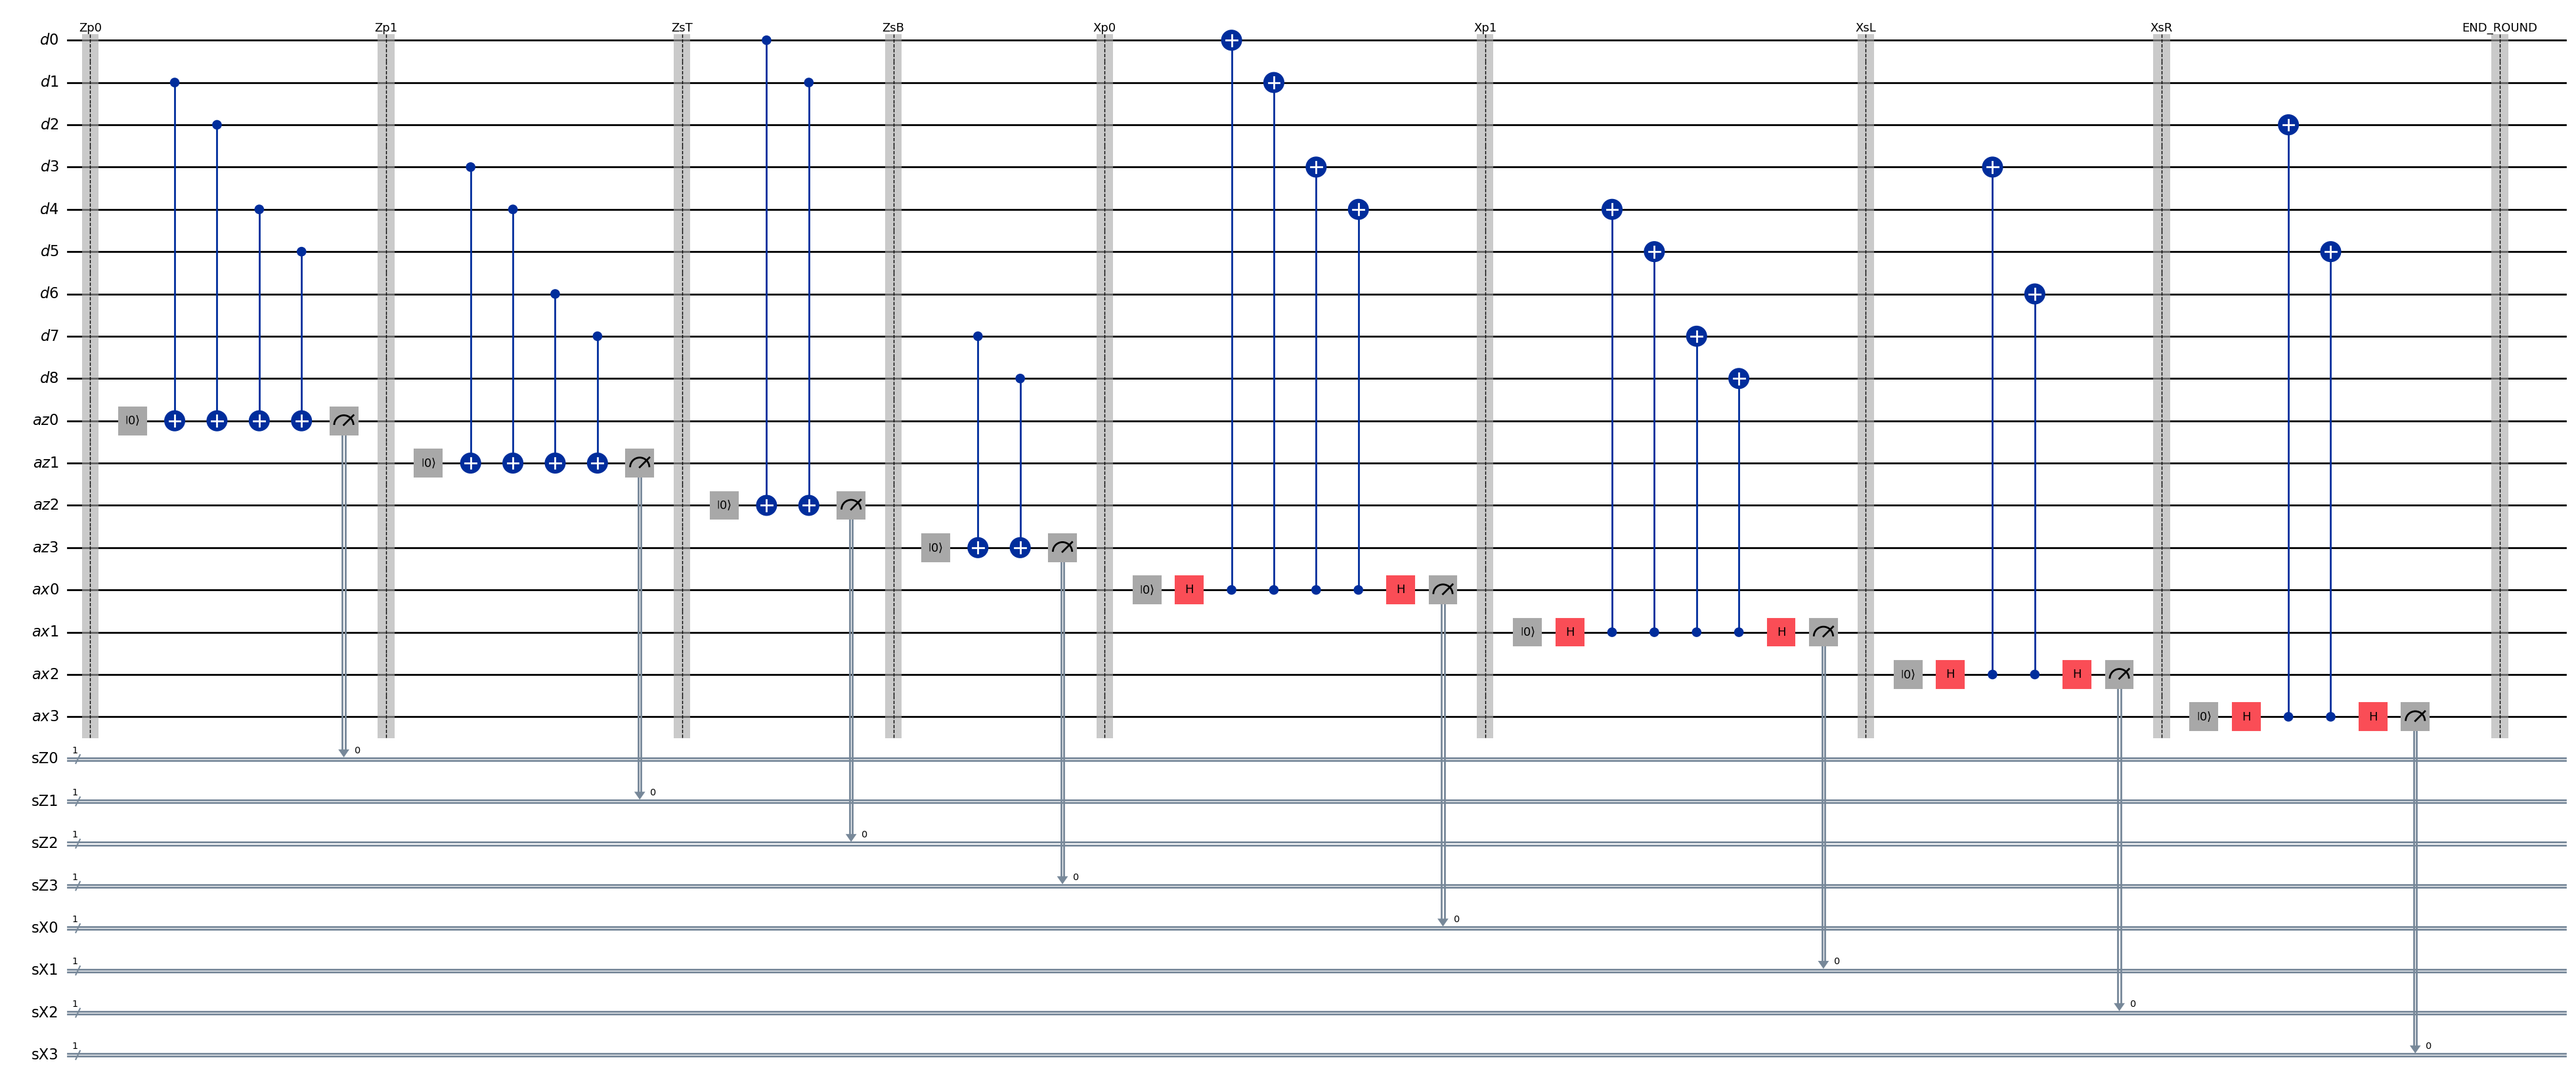

In [6]:
def build_one_round(measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_one_round")

    # Z checks
    for i, stab in enumerate(Z_CHECKS):
        measure_Z_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sZ{i}"), label=stab["name"])

    if measure_both:
        for i, stab in enumerate(X_CHECKS):
            measure_X_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sX{i}"), label=stab["name"])

    qc.barrier(label="END_ROUND")
    return qc

qc_round = build_one_round(measure_both=True)
display(qc_round.draw("mpl", fold=-1))

## 5. 运行一次：返回综合征（8 个测量比特）

Qiskit `get_counts()` 的 key 往往带空格或按某种寄存器顺序拼接。为了稳定解析：
- 先把 key 中非 0/1 的字符全部去掉
- 然后取末尾 8 位（因为本电路总共 8 个 syndrome classical bits）
- 再按 `[sZ0,sZ1,sZ2,sZ3, sX0,sX1,sX2,sX3]` 切片

In [7]:
backend = AerSimulator()

def clean01(s: str) -> str:
    return re.sub(r'[^01]', '', s)

def run_once_get_key(qc):
    tqc = transpile(qc, backend, optimization_level=0)
    res = backend.run(tqc, shots=1).result()
    counts = res.get_counts()
    key = list(counts.keys())[0]
    return key, counts

def parse_syndrome_from_key(key: str):
    raw = key
    c = clean01(key)
    tail = c[-8:]  # last 8 bits are syndrome bits (by construction in this notebook)
    bits = [int(b) for b in tail]  # keep order as printed
    sZ = bits[0:4]
    sX = bits[4:8]
    return raw, tail, sZ, sX, bits

key0, counts0 = run_once_get_key(qc_round)
raw, tail, sZ, sX, bits = parse_syndrome_from_key(key0)

print("raw key:", raw)
print("cleaned(last8):", tail)
print("sZ (Z-check syndrome):", sZ)
print("sX (X-check syndrome):", sX)
print("counts:", counts0)

raw key: 0 0 1 0 0 0 0 0
cleaned(last8): 00100000
sZ (Z-check syndrome): [0, 0, 1, 0]
sX (X-check syndrome): [0, 0, 0, 0]
counts: {'0 0 1 0 0 0 0 0': 1}


## 6. 注入错误 → 综合征 → toy 解码 → 反馈纠错（并输出电路图）

### 重要提醒：为什么“错误在 d1，但纠正可能落在 d7”？
在 surface code（尤其是只做单轮、且 toy decoder 很粗糙的情况下），**同一个综合征对应的“纠错链”通常不唯一**：
- 只要纠错操作与真实错误的组合，等价于某个 stabilizer 或一条同伦等价的链，就能回到码空间。
- 因此，“纠正位置”不一定等于“真实出错位置”。工程上要用多轮 syndrome + 匹配解码（MWPM）来消除歧义。

这里我们先用 **单轮 toy decoder** 演示端到端流程：  
注入单比特 X/Z 错误 → 测量综合征 → 查表给出一个纠错建议 → 再测一轮验证综合征回到全 0。

In [8]:
def inject_error_then_round(err_type="X", err_data="d1", measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Inject_then_round")

    qc.barrier(label="INJECT")
    if err_type.upper() == "X":
        qc.x(Q(qregs, err_data))
    elif err_type.upper() == "Z":
        qc.z(Q(qregs, err_data))
    else:
        raise ValueError("err_type must be 'X' or 'Z'")

    qc.compose(build_one_round(measure_both=measure_both), inplace=True)
    return qc

# Build toy lookup (single-qubit) from stabilizer incidence
def build_single_X_lookup():
    # X error -> flips Z checks that include that data qubit
    lookup = {}
    for d in DATA:
        pattern = tuple(1 if d in stab["data"] else 0 for stab in Z_CHECKS)  # (sZ0..sZ3)
        lookup[pattern] = d
    return lookup

def build_single_Z_lookup():
    # Z error -> flips X checks that include that data qubit
    lookup = {}
    for d in DATA:
        pattern = tuple(1 if d in stab["data"] else 0 for stab in X_CHECKS)  # (sX0..sX3)
        lookup[pattern] = d
    return lookup

X_LOOKUP = build_single_X_lookup()
Z_LOOKUP = build_single_Z_lookup()

def toy_decode_single_X(sZ):
    return X_LOOKUP.get(tuple(sZ), None)

def toy_decode_single_Z(sX):
    return Z_LOOKUP.get(tuple(sX), None)

def feedback_then_round(correction=None, corr_type="X", measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Feedback_then_round")

    qc.barrier(label="FEEDBACK")
    if correction is not None:
        if corr_type.upper() == "X":
            qc.x(Q(qregs, correction))
        elif corr_type.upper() == "Z":
            qc.z(Q(qregs, correction))
        else:
            raise ValueError("corr_type must be 'X' or 'Z'")
    qc.compose(build_one_round(measure_both=measure_both), inplace=True)
    return qc

### 6.1 示例：注入一个 X 错误（在 `d1`）

- X 错误会翻转与之反对易的 **Z stabilizer**（因此看 `sZ`）
- 用 `toy_decode_single_X(sZ)` 给出一个“单错假设”的纠错 qubit
- 反馈施加 X 纠正，再跑一轮，观察 syndrome 是否回到 0

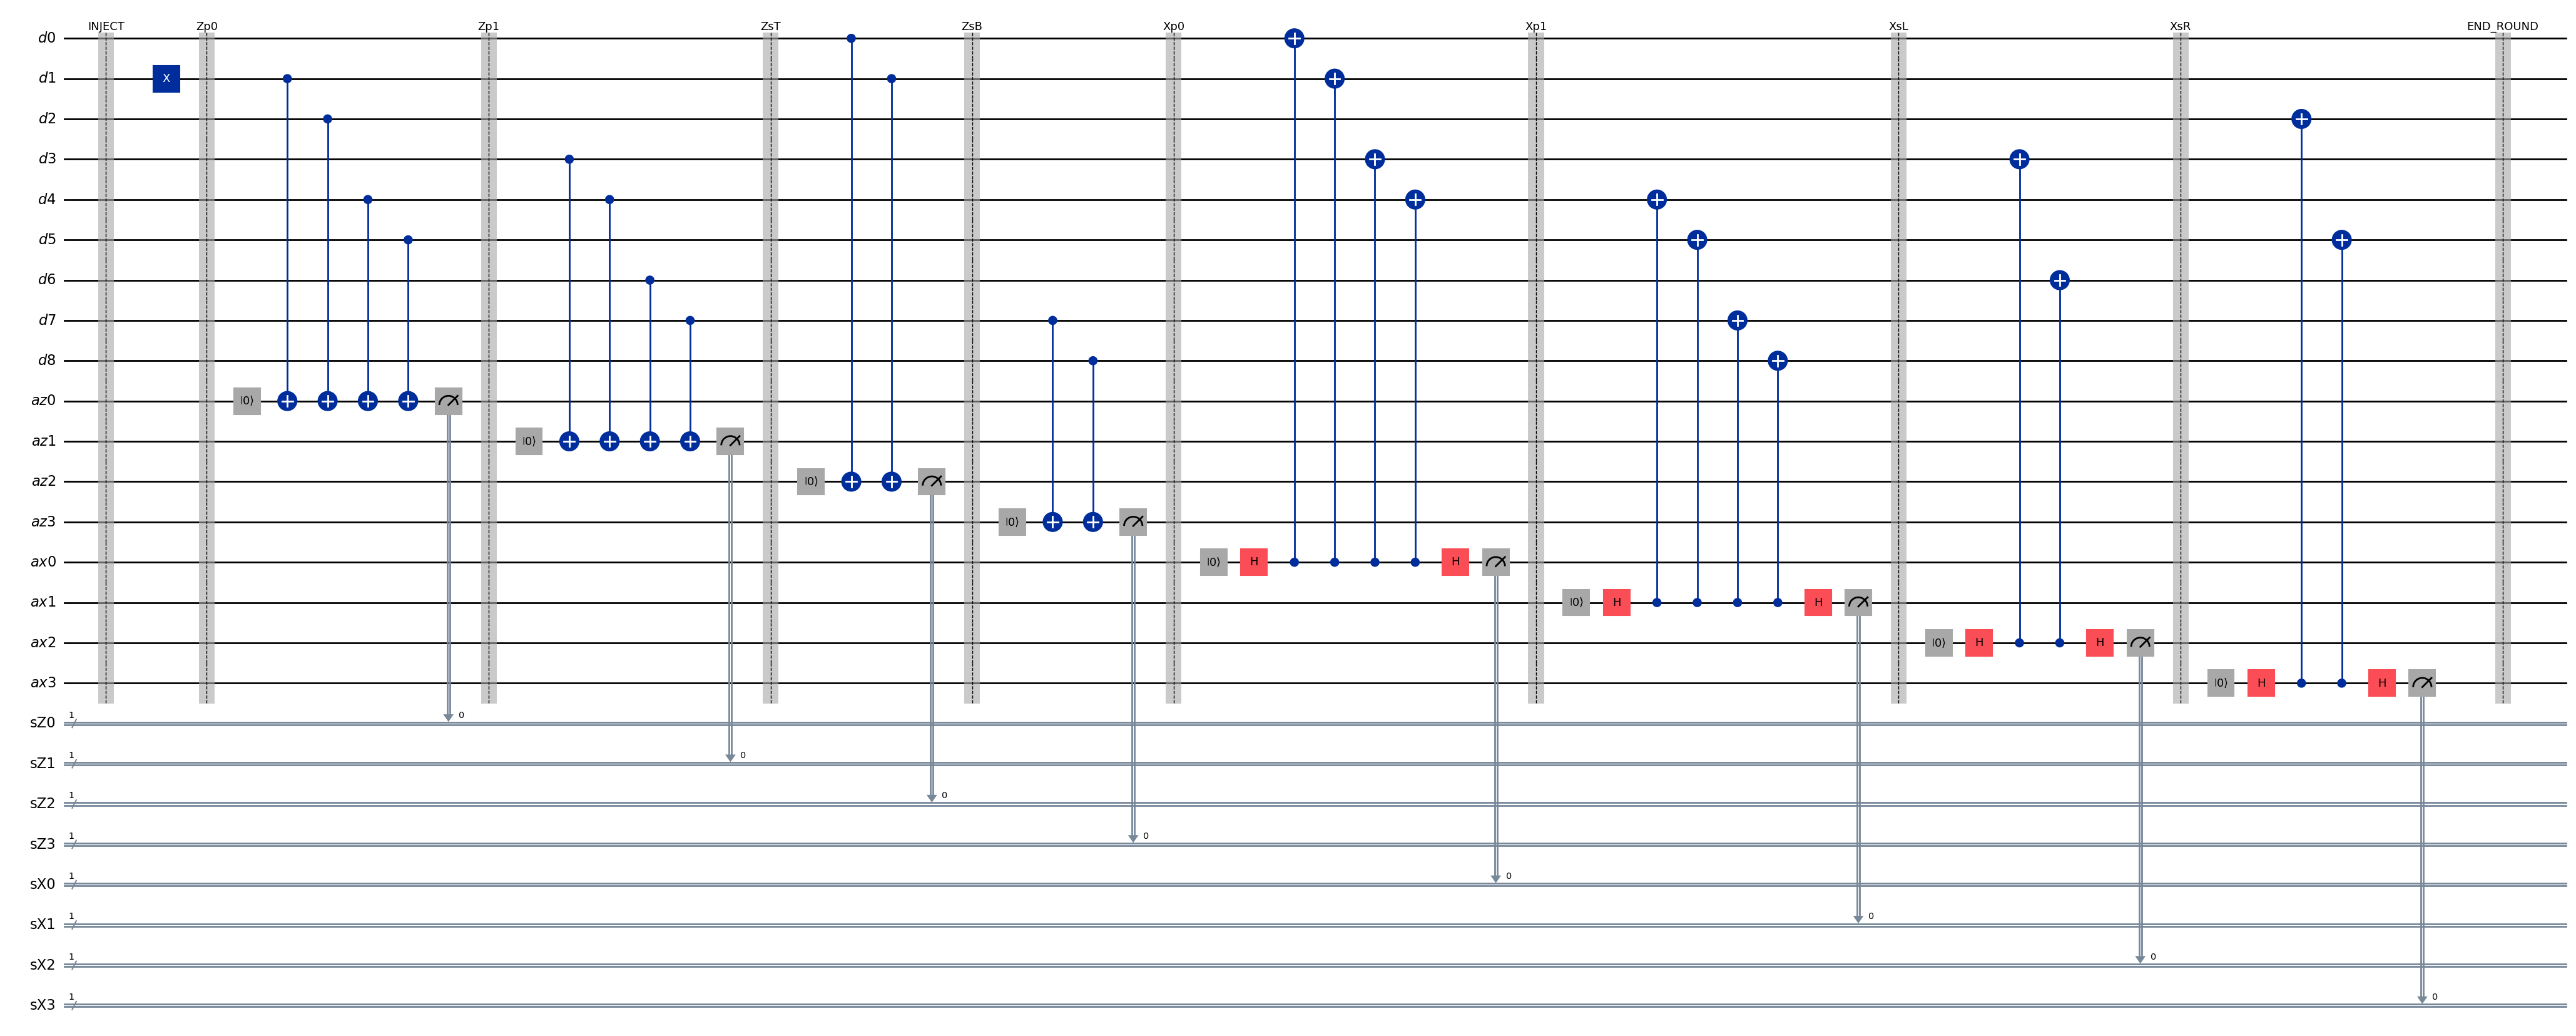

Round-1 counts: {'0 1 0 1 0 1 0 1': 1}
Round-1 sZ: [0, 1, 0, 1] (Z-check syndrome; X errors flip these)
Round-1 sX: [0, 1, 0, 1] (X-check syndrome; Z errors flip these)
Toy decoder guess (single-X): d7


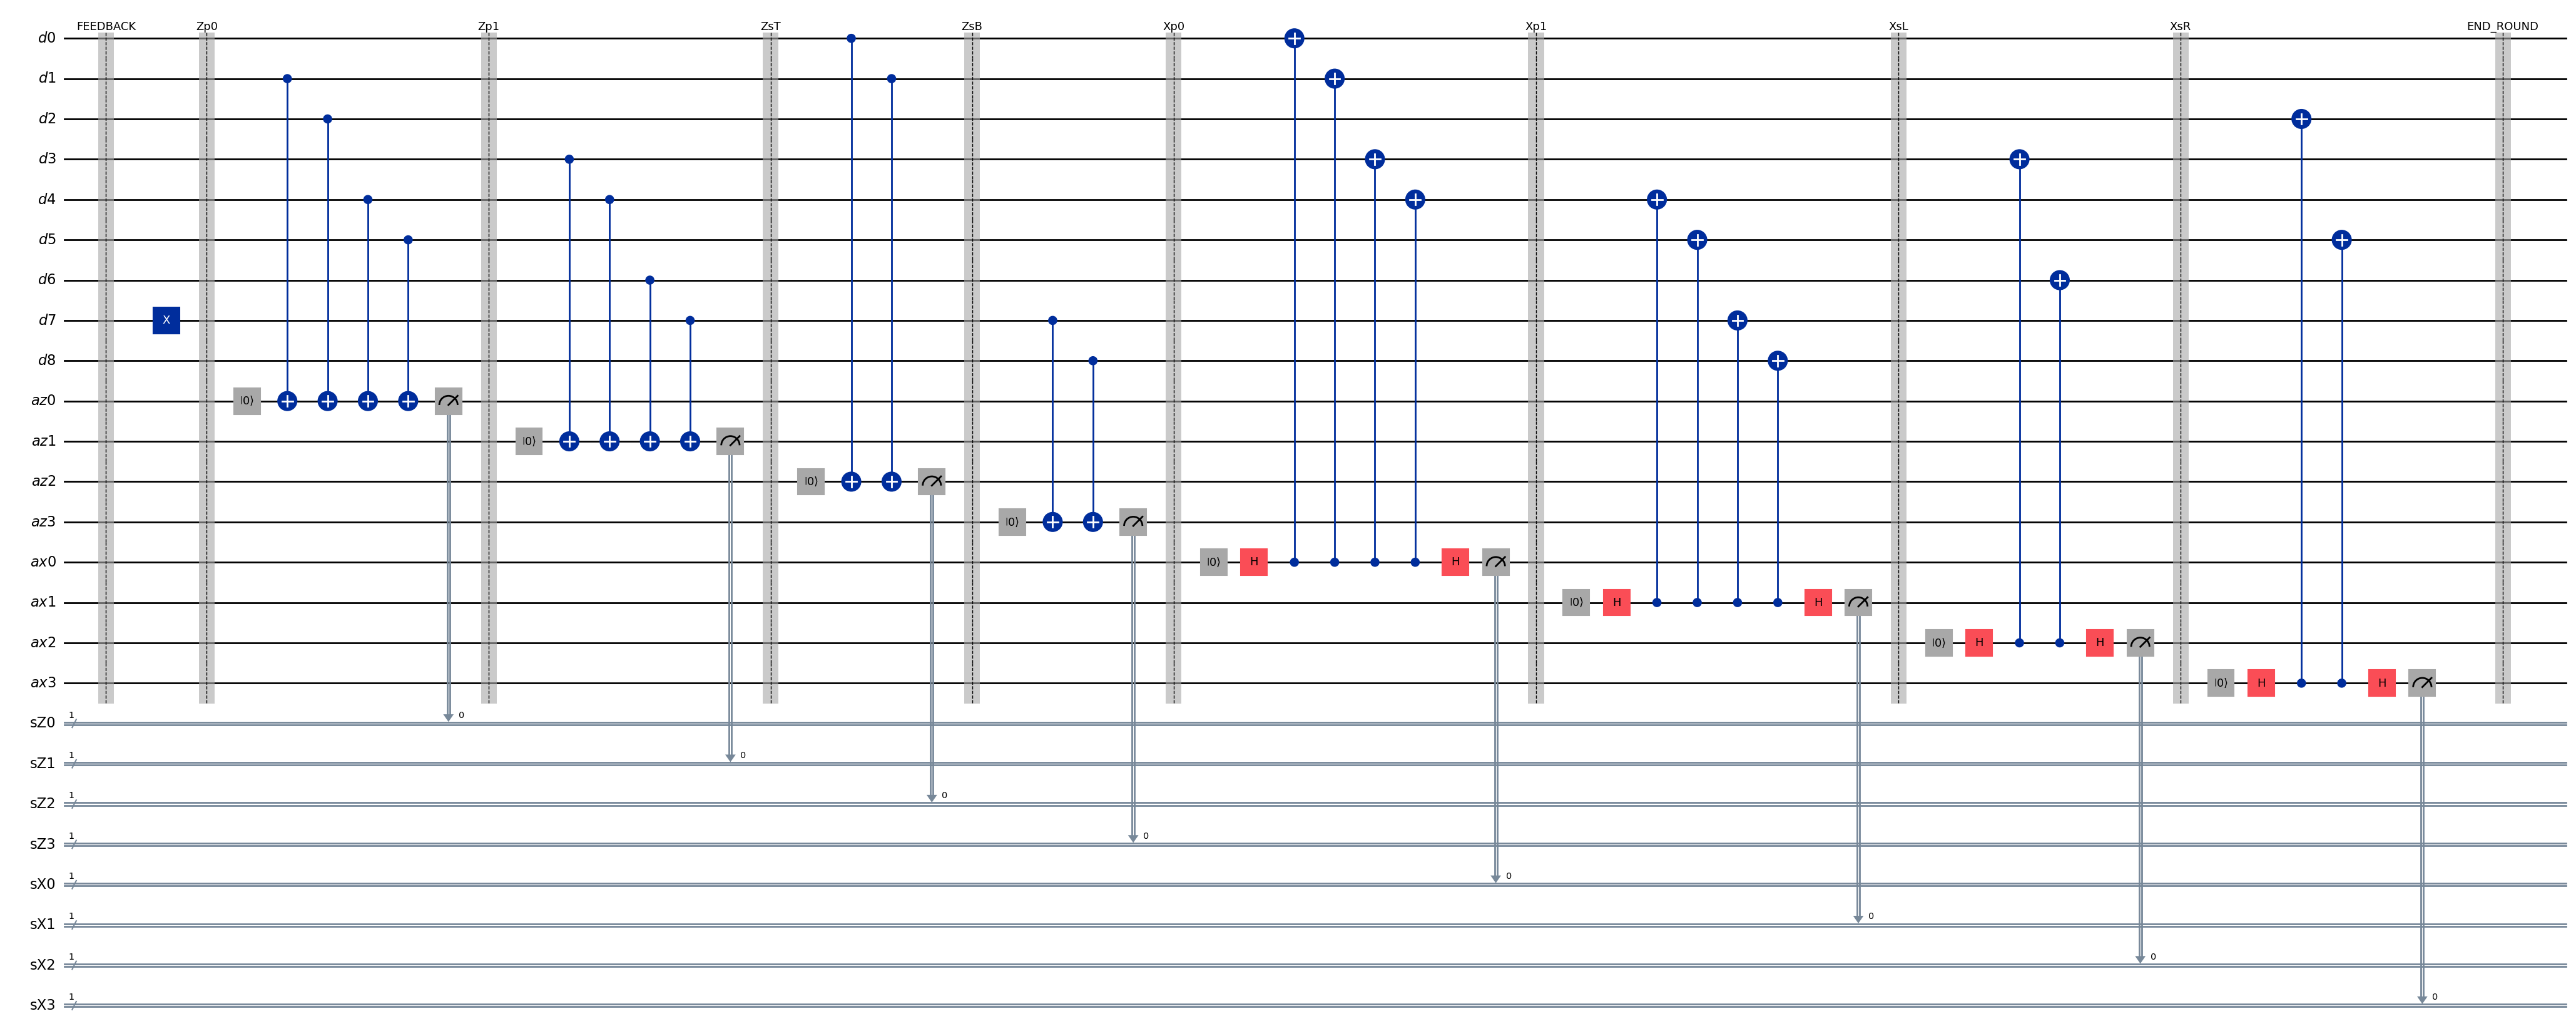

Round-2 counts: {'1 0 1 1 1 0 1 0': 1}
Round-2 sZ: [1, 0, 1, 1] sX: [1, 0, 1, 0]


In [9]:
# --- Example: inject X on d1 ---
qc_err = inject_error_then_round(err_type="X", err_data="d1", measure_both=True)
display(qc_err.draw("mpl", fold=-1))

key1, counts1 = run_once_get_key(qc_err)
raw1, tail1, sZ1, sX1, _ = parse_syndrome_from_key(key1)

print("Round-1 counts:", counts1)
print("Round-1 sZ:", sZ1, "(Z-check syndrome; X errors flip these)")
print("Round-1 sX:", sX1, "(X-check syndrome; Z errors flip these)")

guess = toy_decode_single_X(sZ1)
print("Toy decoder guess (single-X):", guess)

qc_fb = feedback_then_round(correction=guess, corr_type="X", measure_both=True)
display(qc_fb.draw("mpl", fold=-1))

key2, counts2 = run_once_get_key(qc_fb)
raw2, tail2, sZ2, sX2, _ = parse_syndrome_from_key(key2)
print("Round-2 counts:", counts2)
print("Round-2 sZ:", sZ2, "sX:", sX2)

### 6.2 示例：注入一个 Z 错误（在 `d1`）

- Z 错误会翻转与之反对易的 **X stabilizer**（因此看 `sX`）
- 用 `toy_decode_single_Z(sX)` 给出纠错位置
- 反馈施加 Z 纠正，再跑一轮验证

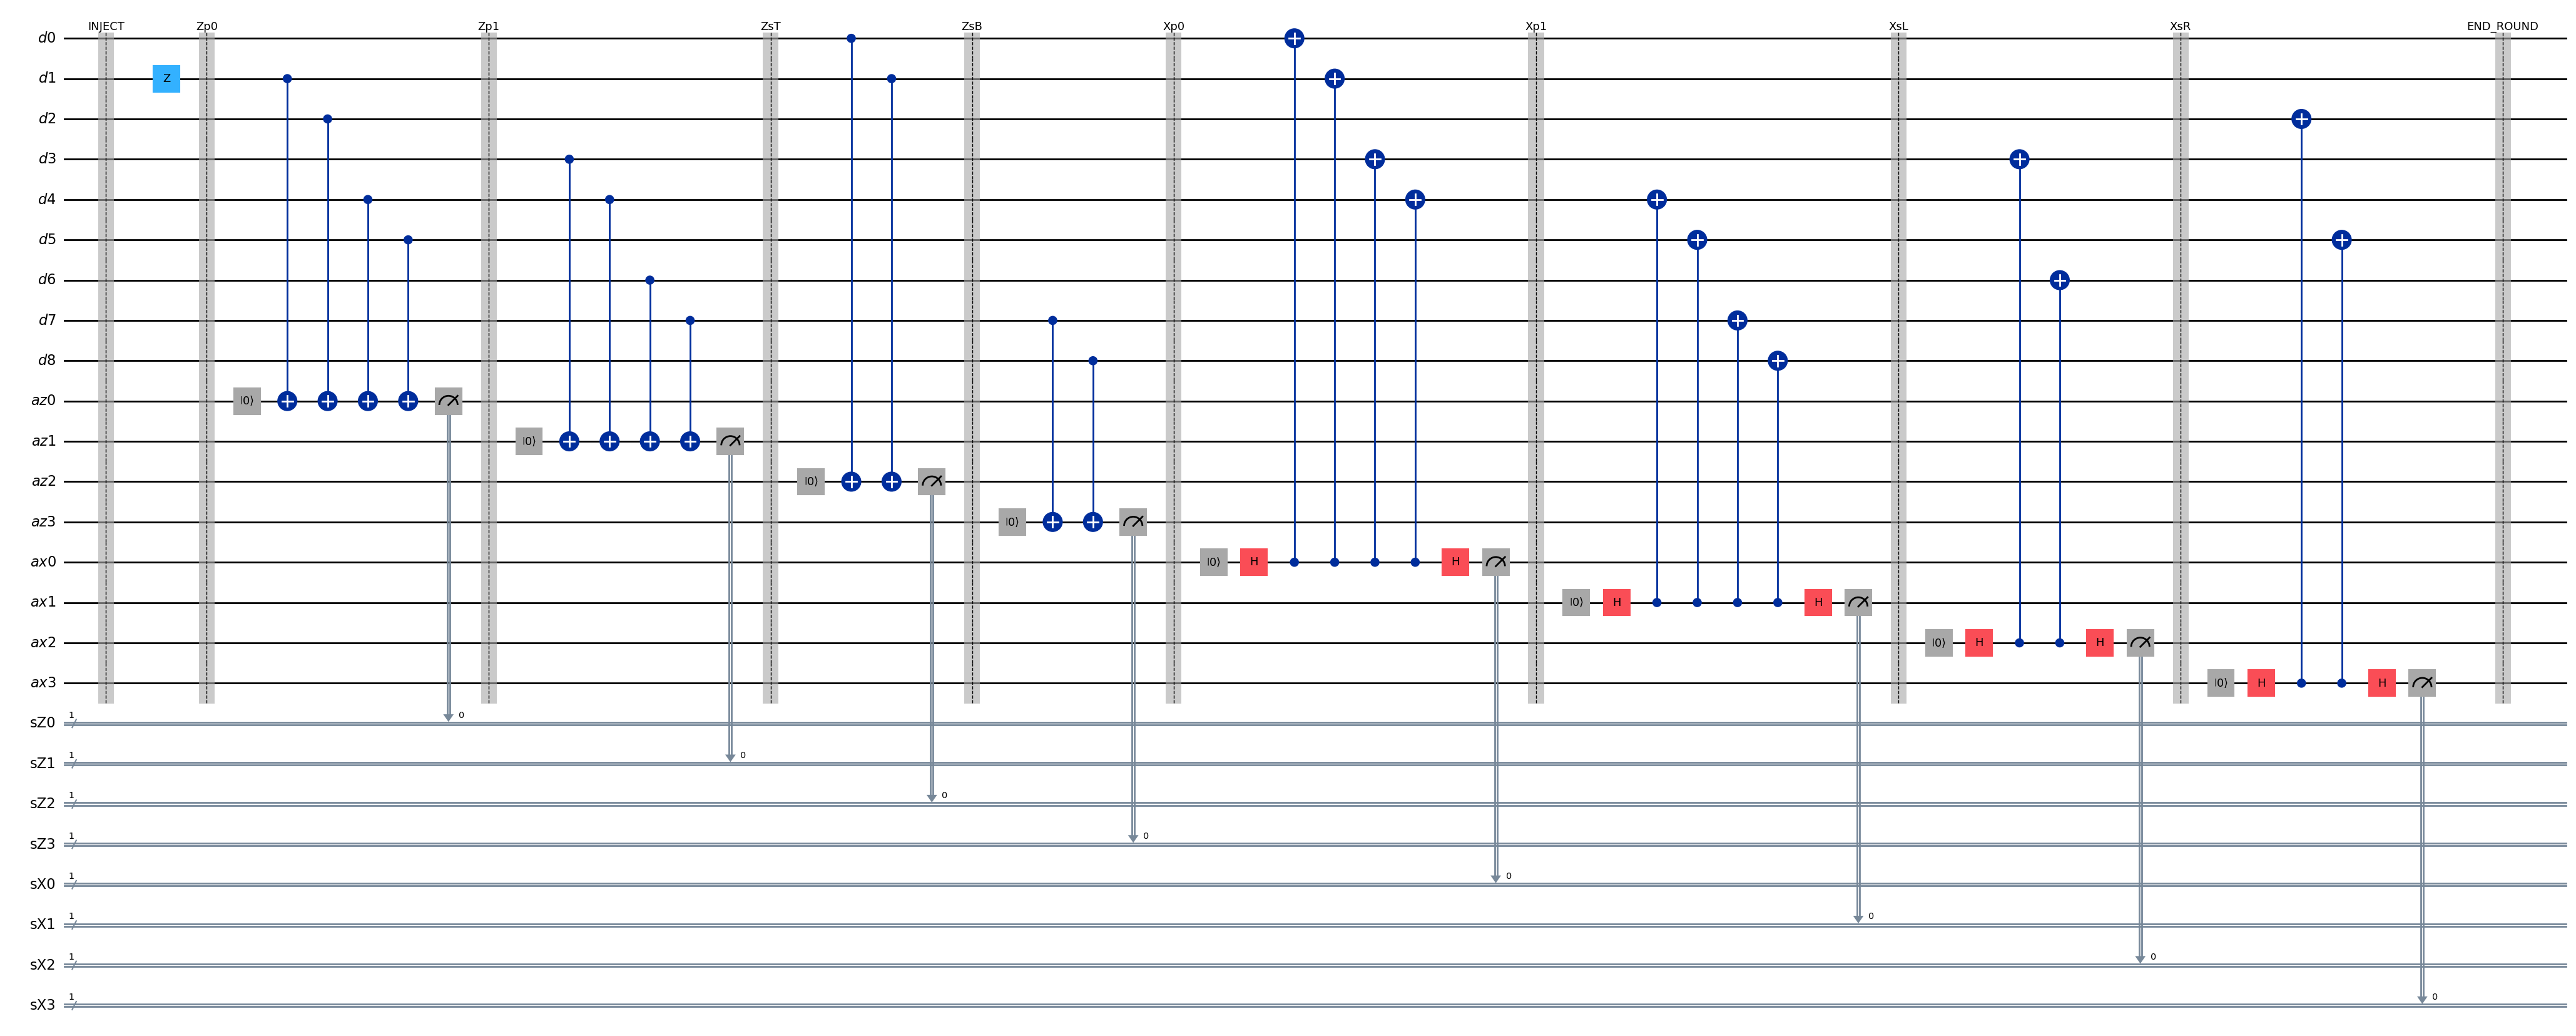

Round-1 counts: {'1 1 1 1 0 0 0 0': 1}
Round-1 sZ: [1, 1, 1, 1]
Round-1 sX: [0, 0, 0, 0] (X-check syndrome; Z errors flip these)
Toy decoder guess (single-Z): None


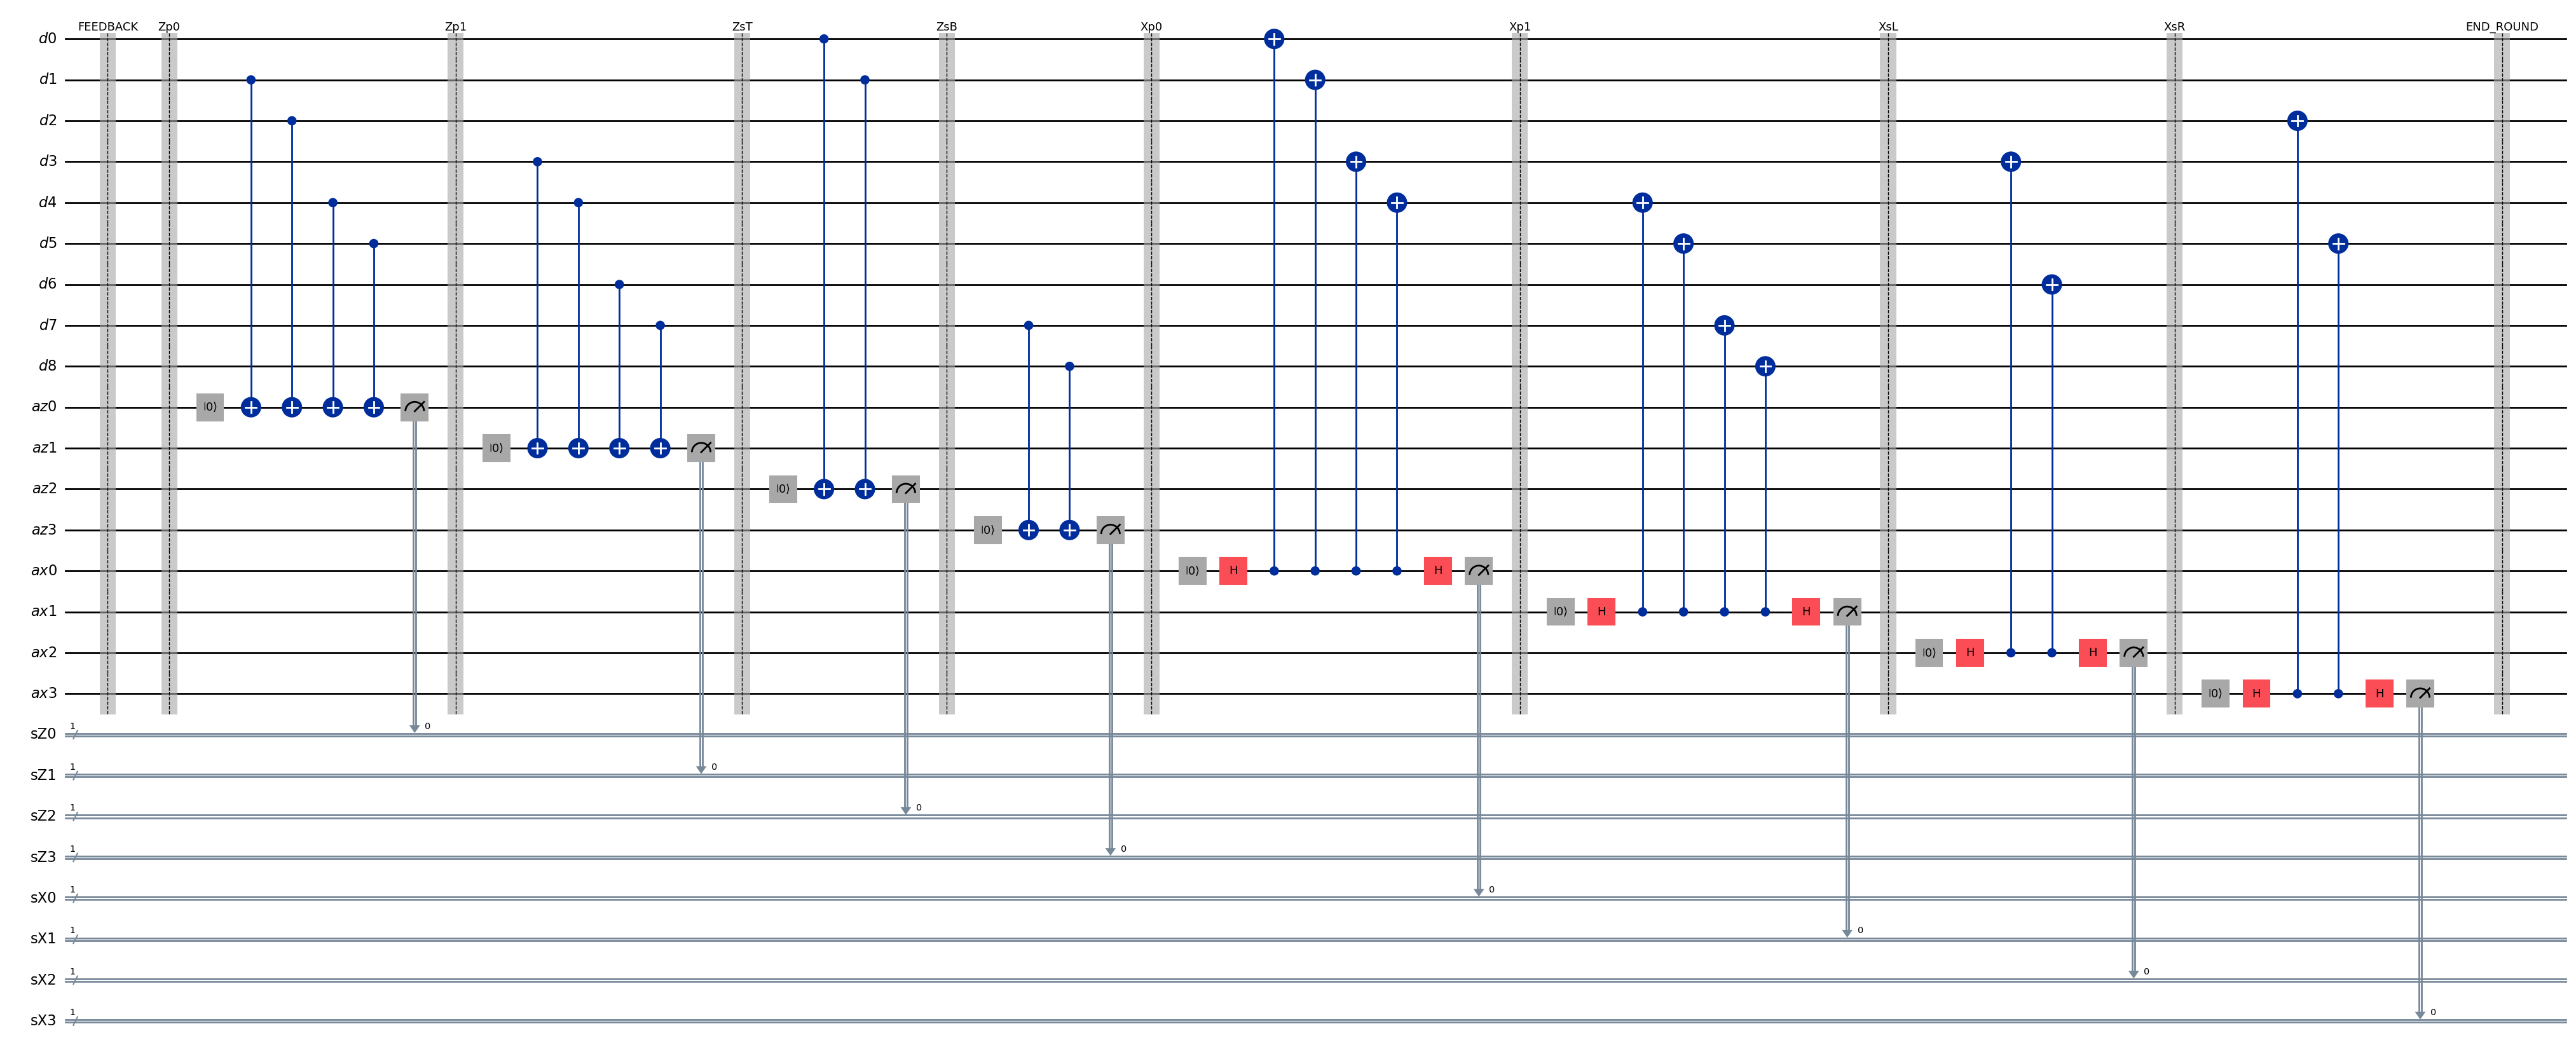

Round-2 counts: {'0 1 0 0 0 0 0 0': 1}
Round-2 sZ: [0, 1, 0, 0] sX: [0, 0, 0, 0]


In [10]:
# --- Example: inject Z on d1 ---
qc_errZ = inject_error_then_round(err_type="Z", err_data="d1", measure_both=True)
display(qc_errZ.draw("mpl", fold=-1))

key1z, counts1z = run_once_get_key(qc_errZ)
raw1z, tail1z, sZ1z, sX1z, _ = parse_syndrome_from_key(key1z)

print("Round-1 counts:", counts1z)
print("Round-1 sZ:", sZ1z)
print("Round-1 sX:", sX1z, "(X-check syndrome; Z errors flip these)")

guessZ = toy_decode_single_Z(sX1z)
print("Toy decoder guess (single-Z):", guessZ)

qc_fbZ = feedback_then_round(correction=guessZ, corr_type="Z", measure_both=True)
display(qc_fbZ.draw("mpl", fold=-1))

key2z, counts2z = run_once_get_key(qc_fbZ)
raw2z, tail2z, sZ2z, sX2z, _ = parse_syndrome_from_key(key2z)
print("Round-2 counts:", counts2z)
print("Round-2 sZ:", sZ2z, "sX:", sX2z)